In [36]:
import cv2
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import requests
from torchvision import transforms, models
import time
from torch.utils.tensorboard import SummaryWriter
import datetime
import os

# Load TensorBoard extension
%load_ext tensorboard

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [37]:
def load_image(img_path_or_obj, max_size=400, shape=None):
    if isinstance(img_path_or_obj, str) and "http" in img_path_or_obj:
        response = requests.get(img_path_or_obj)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    elif isinstance(img_path_or_obj, str):
        image = Image.open(img_path_or_obj).convert('RGB')
    else:
        image = img_path_or_obj.convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image.to(device)

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

In [38]:
# Load VGG19 model and freeze parameters
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)

def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # content representation
                  '28': 'conv5_1'}
    
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

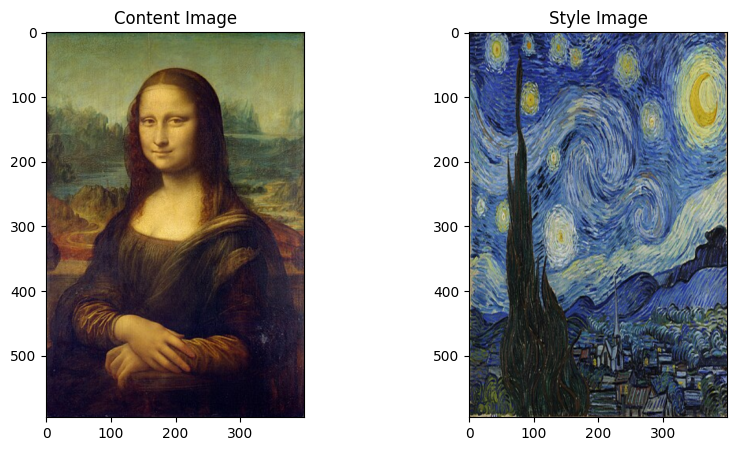

Iteration: 400, Total loss: 26813020.0


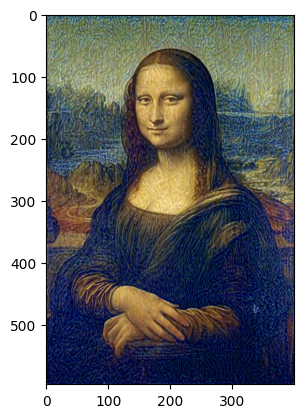

Iteration: 800, Total loss: 9518083.0


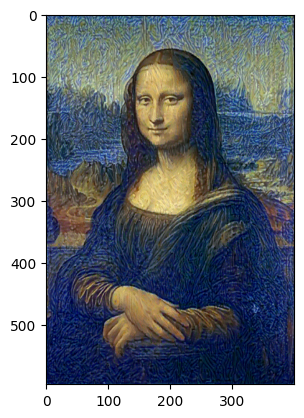

Iteration: 1200, Total loss: 5679254.0


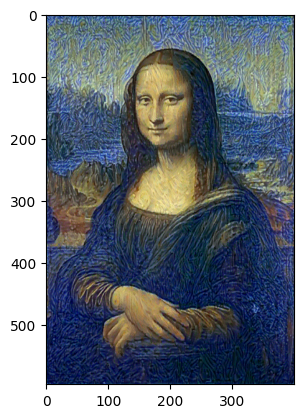

Iteration: 1600, Total loss: 5036110.0


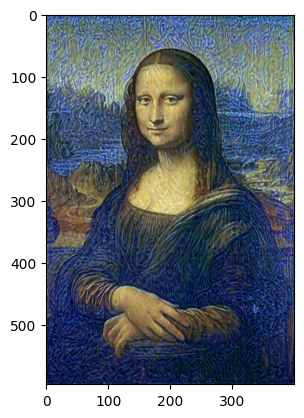

Iteration: 2000, Total loss: 4347776.0


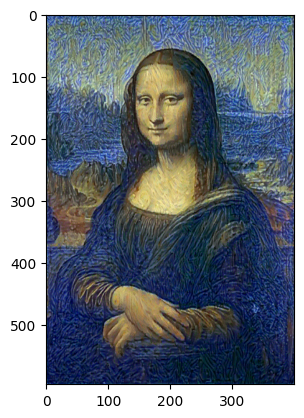

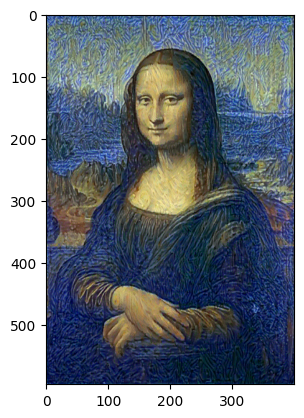

Reusing TensorBoard on port 6006 (pid 29020), started 2:28:06 ago. (Use '!kill 29020' to kill it.)

In [39]:
def style_transfer_with_metrics(content, style, content_weight=1e1, style_weight=1e6, steps=2000, show_every=400):
    log_dir = os.path.join('runs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    writer = SummaryWriter(log_dir)

    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)

    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    target = content.clone().requires_grad_(True).to(device)

    optimizer = optim.Adam([target], lr=0.003)
    scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

    style_weights = {'conv1_1': 1.,
                     'conv2_1': 0.75,
                     'conv3_1': 0.2,
                     'conv4_1': 0.2,
                     'conv5_1': 0.2}

    for ii in range(1, steps+1):
        target_features = get_features(target, vgg)
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            _, d, h, w = target_feature.shape
            target_gram = gram_matrix(target_feature)
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / (d * h * w)

        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        scheduler.step()

        writer.add_scalar('Loss/total_loss', total_loss.item(), ii)
        writer.add_scalar('Loss/content_loss', content_loss.item(), ii)
        writer.add_scalar('Loss/style_loss', style_loss.item(), ii)

        if ii % show_every == 0:
            print('Iteration: {}, Total loss: {}'.format(ii, total_loss.item()))
            plt.imshow(im_convert(target))
            plt.show()

    writer.close()
    return target

content = load_image('./MonaLisa.jpg')
# Load content and style images
content_image_path = './MonaLisa.jpg'
style_image_path = './StarryNight.jpg'

content = load_image(content_image_path)
style = load_image(style_image_path, shape=content.shape[-2:])

# Display the content and style images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Content Image')
plt.imshow(im_convert(content))

plt.subplot(1, 2, 2)
plt.title('Style Image')
plt.imshow(im_convert(style))

plt.show()

# Perform style transfer
output = style_transfer_with_metrics(content, style)
plt.imshow(im_convert(output))
plt.show()

# Start TensorBoard
%tensorboard --logdir runs